In [389]:
import glob
import cv2
from PIL import Image, ImageDraw
import numpy as np
import scipy
import random
import math
import json
from Card import Card
from PerspectiveTransform import PerspectiveTransform

In [29]:
# !wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz;tar xf dtd-r1.0.1.tar.gz

### TO DO:
#### Data generation
- [x]  make sure that at least one corner of every card is fully visible
- [x]  return polygon data for generated image
- [ ]  check if size of background is appropriate for the size and number of cards (if the background is too big it will take long to generate image, if it's too small, the cards might overlap)
- [ ]  fix rotation of polygons (everything works fine if the cards are not rotated)
- [ ]  remove/clip polygons that do not fit in the image
- [ ]  remove label polygons that are obscured by other cards

In [30]:
def imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [73]:
def rotate(image, angleInDegrees, point=None):
    h, w = image.shape[:2]
    if not point:
        point = (w / 2, h / 2)

    rot = cv2.getRotationMatrix2D(point, angleInDegrees, 1)

    rad = math.radians(angleInDegrees)
    sin = math.sin(rad)
    cos = math.cos(rad)
    b_w = int((h * abs(sin)) + (w * abs(cos)))
    b_h = int((h * abs(cos)) + (w * abs(sin)))

    rot[0, 2] += ((b_w / 2) - point[0])
    rot[1, 2] += ((b_h / 2) - point[1])

    outImg = cv2.warpAffine(image, rot, (b_w, b_h), flags=cv2.INTER_LINEAR)
    return outImg

In [183]:
def overlay(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop

In [741]:
def rotate_polygon(pts,cnt,ang):
    rad = math.radians(-ang)
    sin = math.sin(rad)
    cos = math.cos(rad)
    '''pts = {} Rotates points(nx2) about center cnt(2) by angle ang(1) in radian'''
    return np.dot(pts-cnt,scipy.array([[cos,sin],[-sin,cos]]))+cnt

In [816]:
def create_canvas(background, cards_paths, n=10, zoom=0.05):
    coords = []
    metadata = {}
    canvas = background[:, :, :3].copy()
    cards = cards_paths.copy()
    
    max_y, max_x, _ = canvas.shape
    random.shuffle(cards)
    for card_path in cards[:n]:
        card = cv2.imread(card_path+".png", -1)
        #Perspective Transformation
        annots =  json.load(open(card_path+".json",'r'))
        card_polygon = annots['card_polygon']
        label_polygons = annots['label_polygons']
        augmented_card = change_perspective({'image':card,'label_polygons':label_polygons,'card_polygon':card_polygon})
        
        card = augmented_card['image']
        card = cv2.resize(card, None, fx=zoom, fy=zoom)
        
        old_y, old_x, _ = card.shape
        
#         degrees = random.randint(0, 360)
#         card = rotate(card, degrees)
        degrees = 0
    
        alpha_mask = card[:, :, 3] / 255.0
        card_rgb = card[:, :, :3]
        
        card_y, card_x, _ = card.shape
        tries = 0
        while(True):
            repeat = False
            x = random.randint(int(-card_x/2), max_x-int(card_x/2))
            y = random.randint(int(-card_y/2), max_y-int(card_y/2))
            xy = np.array((x, y))
            
            new_card_poly = rotate_polygon(np.array(augmented_card['card_polygon']) * zoom + xy[None,:], (old_x / 2 + x, old_y / 2 + y), degrees)
            new_label_poly = [rotate_polygon(np.array(poly) * zoom + xy[None,:], (old_x / 2 + x, old_y / 2 + y), degrees)
                              for poly in augmented_card['label_polygons']]

            for point in coords:
                if np.linalg.norm(xy-point) < max(card.shape):
                    repeat = True
                    tries += 1
                    break
            if not repeat:
                coords.append(xy)
                overlay(canvas, card_rgb, x, y, alpha_mask)
                metadata[card_path.split("/")[-1]] = {'label_polygons':new_label_poly,'card_polygon':new_card_poly}
                break
            if tries > 50:
                break
                
        test = Image.fromarray(canvas) 
        for card_meta in metadata:
            for polygon in  metadata[card_meta]['label_polygons']:
                polygon = [tuple(i) for i in polygon]
                ImageDraw.Draw(test).polygon(polygon,fill=255, outline=255)

            polygon = [tuple(i) for i in metadata[card_meta]['card_polygon']]
            ImageDraw.Draw(test).line(polygon, fill="blue", width=5)
    imshow(np.array(test))
    
    return canvas, metadata

In [817]:
change_perspective = PerspectiveTransform()

In [818]:
textures = glob.glob("dtd/images/*/*.jpg")
cards = glob.glob("interim_data/*.png")
cards = [f.rstrip(".png") for f in cards]

In [819]:
back_path = random.choice(textures)
back = cv2.imread(back_path, -1)
back = cv2.resize(back, None, fx=2, fy=2)

Tried: 9


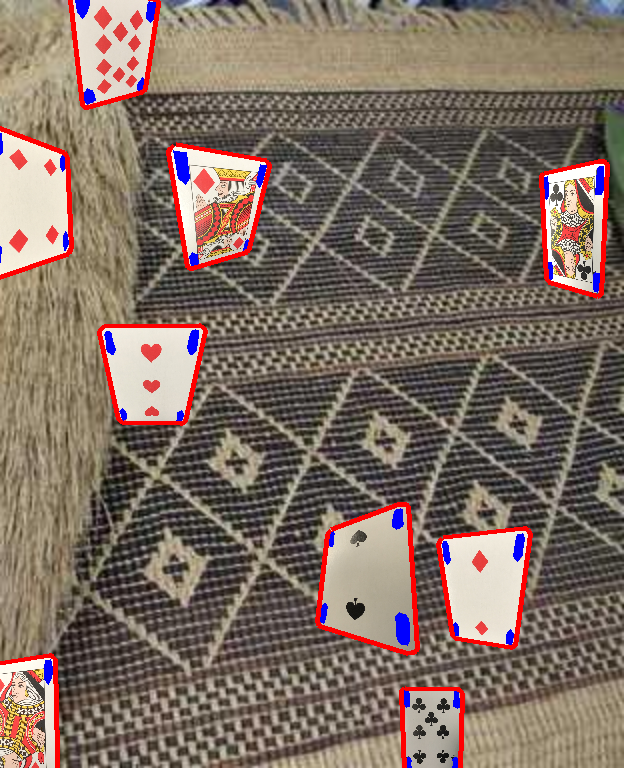

Generated: 9


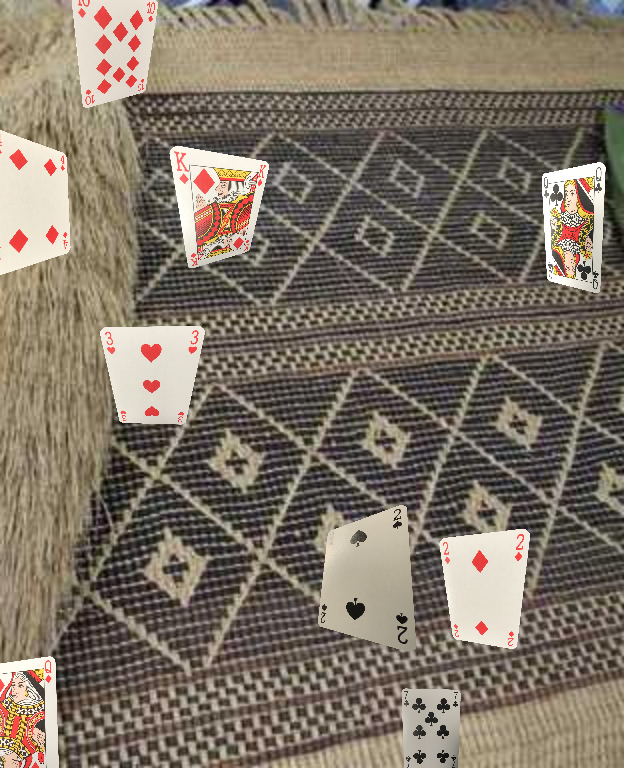

In [820]:
n = random.randint(1, 15)
print(f"Tried: {n}")
out, count = create_canvas(back, cards, n, random.uniform(0.05, 0.15))
print(f"Generated: {len(count)}")
imshow(out)